In [ ]:
import os
from zipfile import ZipFile
import numpy as np
import pandas as pd

Необходимо разархивировать датасет в нужную директорию

In [ ]:
data_path_zip = "/content/drive/MyDrive/PyTorch_5/nturgbd_skeletons_s001_to_s017.zip"
extract_dir = "/content/drive/MyDrive/PyTorch_5/SK"
with ZipFile(data_path_zip) as zf:
    zf.extractall(extract_dir)

Соответствующие пути для содержимого архива и файла txt

In [ ]:
data_path = "/content/drive/MyDrive/PyTorch_5/SK/skeletons/"
#### список отсутсвующих элементов так же будет доступен 
broken_files_path = "/content/drive/MyDrive/PyTorch_5/missing_skeletons.txt"

In [ ]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [ 44, 14, 34, 40, 10, 50, 5, 24] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

Функция, которая позволяет нам считать данные для каждого класса

In [ ]:
def read_data(data_path, broken_files_path):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    raw_files = os.listdir(data_path)
    num_frames = 0

    for filename in raw_files:
        if filename not in broken_files:
            action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
            subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
            camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
            if action_class in training_classes and camera_id in training_cameras:  #and subject_id in training_subjects:
                if action_class in action_classes:
                    if files_counter[action_class] < 120:
                        files.append([filename,action_classes[action_class]])
                        files_counter[action_class] = files_counter[action_class] + 1
                else:
                    action_classes.update({action_class : counter})
                    files_counter.update({action_class : 1})
                    counter+=1
                    files.append([filename,action_classes[action_class]])
#                     labels.append([action_class])
    print("action classes: ", action_classes)
    print("action files: ", files_counter)
    
    return files, action_classes

In [ ]:
def get_nonzero_std(s): 
    index = s.sum(-1).sum(-1) != 0  
    s = s[index]
    if len(s) != 0:
        s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
    else:
        s = 0
    return s

# Функция фильтр для того, что бы найти только координаты x,y,z(т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
def read_skeleton_filter(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []
        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton_filter(file)
    data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

                else:
                    pass

    return data

В этой функции меняем количество фреймов подаваемых на вход модели
В задании нужно пронаблюдать зависимость качества обучения модели от количества кадров, которые мы подаем в модель. Т.е. то, cколько кадров у нас отведено на один блок. В ноутбуке мы обучали модель на 45 кадрах. Вам предлагается посмотреть в меньшую или большую сторону.



In [ ]:
def create_coords_blocks(test_file, chonk_len = 35):   
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(data_path + test_file[0])[0]
    label = test_file[1]
    slice_len = chonk_len * int(len(test_frames)/chonk_len)


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == chonk_len:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
            
    return blocks, new_labels

In [ ]:
##### список файлов с лейблами на каждый файл 
working_files_with_labels, action_classes = read_data(data_path, broken_files_path)

action classes:  {44: 0, 14: 1, 34: 2, 40: 3, 10: 4, 50: 5, 5: 6, 24: 7}
action files:  {44: 120, 14: 120, 34: 120, 40: 120, 10: 120, 50: 120, 5: 120, 24: 120}


In [ ]:
LABELS = {v: k for k, v in action_classes.items()}
print(LABELS)

{0: 44, 1: 14, 2: 34, 3: 40, 4: 10, 5: 50, 6: 5, 7: 24}


In [ ]:
len(working_files_with_labels)

960

In [ ]:
print(working_files_with_labels)

[['S014C002P037R001A044.skeleton', 0], ['S008C001P030R001A014.skeleton', 1], ['S009C003P019R002A044.skeleton', 0], ['S011C002P017R002A034.skeleton', 2], ['S013C002P015R002A044.skeleton', 0], ['S008C003P030R002A014.skeleton', 1], ['S014C003P039R002A034.skeleton', 2], ['S006C001P007R002A014.skeleton', 1], ['S002C003P013R001A044.skeleton', 0], ['S003C001P016R001A034.skeleton', 2], ['S011C003P017R002A040.skeleton', 3], ['S013C001P027R001A044.skeleton', 0], ['S007C002P027R002A010.skeleton', 4], ['S007C001P017R002A050.skeleton', 5], ['S006C003P017R002A044.skeleton', 0], ['S013C003P008R001A044.skeleton', 0], ['S011C002P016R002A034.skeleton', 2], ['S007C002P008R002A014.skeleton', 1], ['S010C002P015R002A050.skeleton', 5], ['S010C002P025R001A005.skeleton', 6], ['S002C003P012R002A014.skeleton', 1], ['S012C003P016R002A005.skeleton', 6], ['S011C003P017R002A014.skeleton', 1], ['S013C003P016R002A050.skeleton', 5], ['S009C001P015R002A044.skeleton', 0], ['S010C001P025R001A005.skeleton', 6], ['S010C002P

In [ ]:
data = []
labels = []
##########################################################################
numbers = {x: 0 for x in range(len(action_classes))} #####
##################################################################
for file in working_files_with_labels:
    frames_blocks, label = create_coords_blocks(file)
    if label != [] and numbers[label[0]] <= 150:
        numbers[label[0]] = numbers[label[0]] + len(label)
        data = data + frames_blocks
        labels = labels + label
data_np = np.asarray(data)
labels_np = np.asarray(labels)

data_sq = data_np.reshape(len(data_np), -1)
test_data = pd.DataFrame(data_sq)
test_labels = pd.DataFrame(labels_np)
test_data['labels'] = test_labels

Итоговый файл для загрузки

In [ ]:
test_data.to_csv("skeletons_classes_35.csv", index = False)

NameError: ignored

In [ ]:
from torchvision import transforms

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch import optim
import time
import math

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [ ]:
skeletons = pd.read_csv("skeletons_classes_35.csv")

In [ ]:
LABELS = {0: "headache", 1: "wear jacket", 2:  "rub two hands together", 3: "cross hands in front", 4: "clapping", 5: "slapping other person", 6: "drop", 7:  "kicking something"}

In [ ]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,labels
0,-0.110578,0.165554,3.742496,-0.160390,0.456740,3.629033,-0.191902,0.745907,3.517724,-0.233563,0.841947,3.546097,-0.255945,0.586194,3.428878,-0.231815,0.392934,3.479745,-0.177386,0.203693,3.539481,-0.171919,0.169102,3.591995,-0.170232,0.605299,3.460537,-0.183199,0.332012,3.493649,-0.245992,0.088710,3.593519,-0.261579,0.029400,3.633067,-0.167048,0.158798,3.734176,-0.117432,...,-0.282623,0.151462,3.726731,-0.139473,-0.128355,3.905732,-0.128918,-0.495479,4.011112,-0.158818,-0.544631,3.918616,-0.171226,0.146795,3.679225,-0.224953,-0.158432,3.794661,-0.162005,-0.535874,3.961334,-0.205520,-0.602862,3.922297,-0.192592,0.661955,3.529910,-0.320168,0.780955,3.401313,-0.299214,0.695292,3.376007,-0.353337,0.777761,3.401335,-0.319847,0.697825,3.378924,0.0
1,-0.227082,0.153707,3.737444,-0.205563,0.448503,3.621592,-0.188903,0.731287,3.494673,-0.248611,0.802914,3.497801,-0.255655,0.585055,3.406049,-0.398257,0.439023,3.373261,-0.361457,0.635650,3.386219,-0.336959,0.698129,3.399756,-0.127427,0.593246,3.453730,-0.307924,0.460749,3.359283,-0.389783,0.640786,3.382567,-0.348760,0.662373,3.394476,-0.280004,0.150356,3.714141,-0.137217,...,-0.281747,0.149119,3.708046,-0.136884,-0.125617,3.925501,-0.097572,-0.492971,4.058024,-0.119666,-0.557340,3.979377,-0.165434,0.142456,3.676856,-0.221257,-0.158451,3.794039,-0.183672,-0.498453,3.925175,-0.159300,-0.565721,3.825293,-0.201968,0.659269,3.520385,-0.311360,0.754687,3.410310,-0.287400,0.672756,3.393917,-0.467357,0.738297,3.439263,-0.430465,0.669900,3.428097,0.0
2,-0.037120,-0.529844,3.196127,-0.020126,-0.212045,3.229157,-0.002146,0.100497,3.249228,-0.023377,0.244549,3.261299,-0.151932,-0.043944,3.373470,-0.195765,-0.269656,3.386152,-0.165338,-0.427568,3.139122,-0.190415,-0.453155,3.108771,0.114692,-0.029478,3.124918,0.152207,-0.239422,3.055003,-0.093875,-0.362889,3.067510,-0.154414,-0.407446,3.073234,-0.087593,-0.532938,3.206358,-0.116667,...,-0.093742,-0.505647,2.907959,-0.030305,-0.754397,2.738103,-0.425534,-0.864420,2.797002,-0.375337,-0.798370,2.733720,0.003470,-0.508971,3.157621,0.095714,-0.846280,3.164288,0.118228,-1.157324,3.228918,0.087679,-1.242242,3.176007,-0.046793,-0.088979,2.950454,-0.126086,-0.638089,2.697150,-0.173787,-0.568889,2.696800,-0.078281,-0.157559,2.984520,-0.074679,-0.147777,2.980950,1.0
3,-0.012773,-0.529072,3.048971,-0.020578,-0.259930,3.002631,-0.014458,0.012057,2.940946,-0.052329,0.156459,3.074113,-0.114020,-0.029522,2.919169,-0.204991,-0.294295,2.836905,-0.163657,-0.494003,2.771952,-0.139357,-0.541682,2.725013,0.195544,-0.000660,3.186731,0.170660,-0.204811,3.113867,0.010598,-0.338275,3.136864,-0.042519,-0.383029,3.148690,-0.072842,-0.532007,3.003581,0.033429,...,-0.055170,-0.418629,3.240206,-0.112634,-0.778570,3.333710,-0.054087,-1.188009,3.483277,-0.086162,-1.245032,3.447848,-0.038671,-0.394736,3.156002,0.024223,-0.779089,3.141109,0.112975,-1.176088,3.220782,0.079176,-1.256636,3.163659,-0.033425,0.180406,3.322398,0.066803,0.164190,2.400077,0.045451,0.203535,2.437390,0.001310,0.380204,3.162894,0.037250,0.354001,3.062800,1.0
4,-0.047106,-0.412445,3.235339,-0.038191,-0.071661,3.290411,-0.031392,0.257797,3.327315,-0.093013,0.370868,3.380670,0.110116,0.197215,3.059568,0.067655,0.167216,2.761608,0.076868,0.161195,2.524500,0.080048,0.159445,2.449652,0.116586,0.114643,3.433924,0.093295,0.198710,3.144887,0.014961,0.393039,3.108371,-0.008873,0.444485,3.158270,-0.054637,-0.418274,3.240051,-0.115073,...,-0.075021,-0.500951,3.216806,-0.062404,-0.858851,3.323531,-0.050386,-1.191924,3.473920,-0.089267,-1.246076,3.445071,0.050032,-0.498513,3.125206,0.080986,-0.792042,3.103729,0.122053,-1.179171,3.211416,0.083150,-1.254722,3.160029,-0.014735,0.034849,3.196696,-0.188944,-0.051541,3

In [ ]:
skeletons.shape

(759, 2626)

## **Dataloader**

In [ ]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(35,25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        

        return (item, label) 

In [ ]:
dataset = Skeleton_Dataset(file_path = "skeletons_classes_35.csv", transform=None)

In [ ]:
skel, lab = dataset.__getitem__(41)
skel, lab = dataset[41]

In [ ]:
LABELS[lab]

'wear jacket'

In [ ]:
skel.shape

(35, 75)

In [ ]:
skels_for_draw = skel.reshape(-1,25,3)

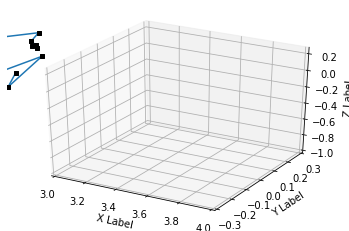

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import numpy as np
from time import sleep



import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((-1.0, 0.25))
    ax.set_xlim((3.0, 4.0))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    #plt.show()

## **Оборачиваем в Даталоадер:**

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)),int(0.25*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

### Инициализируем наши переменные и модель

In [ ]:
class LSTM_net(nn.Module):
    # Для того, что бы инициализировать LSTM нам нужно указать:
    # input_dim - размерность входного тензора. тензор входит в формате (seq_len, batch, input_dim)
    # (batch_size, seq, inp_dim) - if batch_first=True
    # hidden_dim - размерность вектора состояния h
    # output_dim - размерность выхода
    # layer_num - количество скрытых слоев в сети
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [ ]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 4
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=4, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



# **35** **кадров**

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 2.0870  / headache ✓
epoch : 9 iter : 5 (0m 57s) 2.0657  / headache ✗ (wear jacket)
epoch : 18 iter : 10 (1m 56s) 2.0903  / rub two hands together ✗ (kicking something)
epoch : 27 iter : 15 (2m 54s) 2.0598  / rub two hands together ✗ (drop)
epoch : 36 iter : 20 (3m 52s) 2.0574  / rub two hands together ✓
epoch : 45 iter : 25 (4m 51s) 2.0760  / rub two hands together ✗ (slapping other person)
epoch : 54 iter : 30 (5m 50s) 2.1194  / rub two hands together ✗ (headache)
epoch : 63 iter : 35 (6m 49s) 2.0522  / rub two hands together ✗ (wear jacket)
epoch : 72 iter : 40 (7m 47s) 2.1079  / rub two hands together ✗ (kicking something)
epoch : 81 iter : 45 (8m 43s) 2.0743  / rub two hands together ✓
epoch : 90 iter : 50 (9m 39s) 2.0840  / rub two hands together ✗ (kicking something)
epoch : 100 iter : 0 (10m 35s) 2.0716  / rub two hands together ✗ (drop)
epoch : 109 iter : 5 (11m 30s) 2.0970  / rub two hands together ✗ (slapping other person)
epoch : 118 iter : 10 (12

При кол-ве lstm модулей 4, кадров 35 Accuracy of the network: 45.51724137931034

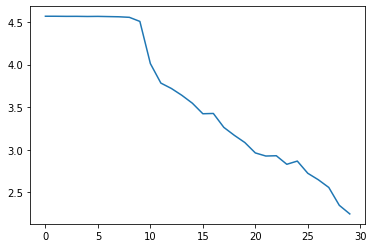

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)

In [ ]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   45.51724137931034


При кол-ве lstm модулей 2, кадров 35
Accuracy of the network:   55.51724137931034 

In [ ]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   55.51724137931034


При кол-ве lstm модулей 10, кадров 35 Accuracy of the network:   10.0

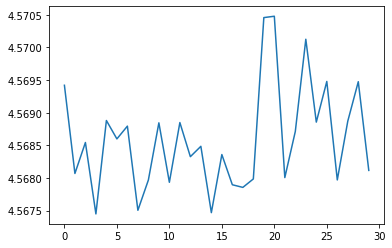

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
#plt.show()

In [ ]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   10.0
